In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
DATASET_PATH = "../dataset/raw"


In [4]:
class_counts = {}

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df


,Image Count
Atomic Dermatitis,1257
Basal Cell Carcinoma,0
Eczema,1677
Melanocytic Nevi,1197
Melanoma,3144
Psoriasis,2055
Tinea Ringworm,1702
Warts Molluscum,2105


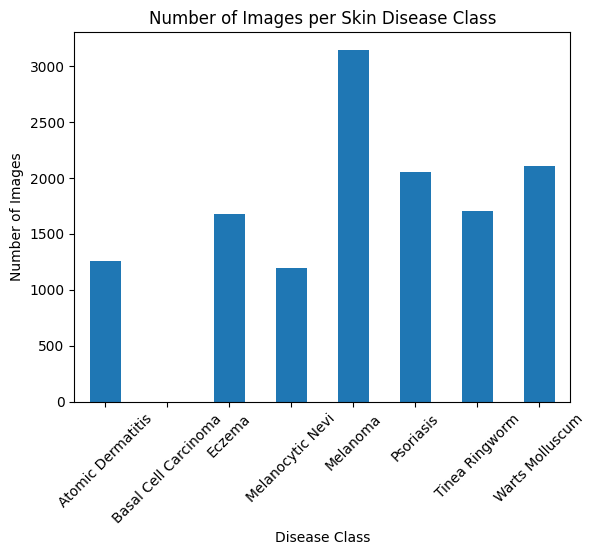

In [5]:
df.plot(kind='bar', legend=False)
plt.title("Number of Images per Skin Disease Class")
plt.ylabel("Number of Images")
plt.xlabel("Disease Class")
plt.xticks(rotation=45)
plt.show()


In [6]:
formats = {}
resolutions = {}

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path)[:5]:  # sample images
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path)

        formats.setdefault(cls, set()).add(img.format)
        resolutions.setdefault(cls, set()).add(img.size)

formats, resolutions


({'Atomic Dermatitis': {'JPEG'},
  'Eczema': {'JPEG'},
  'Melanocytic Nevi': {'JPEG'},
  'Melanoma': {'JPEG'},
  'Psoriasis': {'JPEG'},
  'Tinea Ringworm': {'JPEG'},
  'Warts Molluscum': {'JPEG'}},
 {'Atomic Dermatitis': {(294, 222), (720, 472), (720, 480), (720, 486)},
  'Eczema': {(480, 720), (720, 477), (720, 480)},
  'Melanocytic Nevi': {(600, 450)},
  'Melanoma': {(512, 512)},
  'Psoriasis': {(294, 222), (720, 472), (720, 480), (720, 496)},
  'Tinea Ringworm': {(720, 464), (720, 472), (720, 484)},
  'Warts Molluscum': {(294, 222), (720, 472), (720, 482), (720, 490)}})

In [7]:
corrupted_images = []

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            corrupted_images.append(img_path)

len(corrupted_images)


0

In [8]:
for path in corrupted_images:
    os.remove(path)

print(f"Removed {len(corrupted_images)} corrupted images")


Removed 0 corrupted images


In [ ]:
for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    for i, img_name in enumerate(os.listdir(cls_path)):
        ext = os.path.splitext(img_name)[1]
        new_name = f"{cls.lower()}_{i}{ext}"
        os.rename(
            os.path.join(cls_path, img_name),
            os.path.join(cls_path, new_name)
        )


In [13]:
import hashlib

hashes = {}
duplicates = []

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        with open(img_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()

        if file_hash in hashes:
            duplicates.append(img_path)
        else:
            hashes[file_hash] = img_path

len(duplicates)


584

In [14]:
import hashlib

hashes = {}
duplicates = []

for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        with open(img_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()

        if file_hash in hashes:
            duplicates.append(img_path)
        else:
            hashes[file_hash] = img_path

len(duplicates)


584

In [15]:
for dup in duplicates:
    os.remove(dup)

print(f"Removed {len(duplicates)} duplicate images")


Removed 584 duplicate images


In [16]:
img_path = None

# pick one sample image
for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
    break

img = Image.open(img_path).convert("RGB")
img = img.resize((224, 224))

img_arr = np.array(img) / 255.0

img_arr.shape, img_arr.min(), img_arr.max()


((224, 224, 3),
 np.float64(0.058823529411764705),
 np.float64(0.9882352941176471))

In [18]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)


  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/52/c8/08629657ac6c0da198487ce8cd3de78e02cfde42b7f34117d56a3fe249dc/scipy-1.17.0-cp311-cp311-win_amd64.whl.metadata
  Using cached scipy-1.17.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.17.0-cp311-cp311-win_amd64.whl (36.4 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

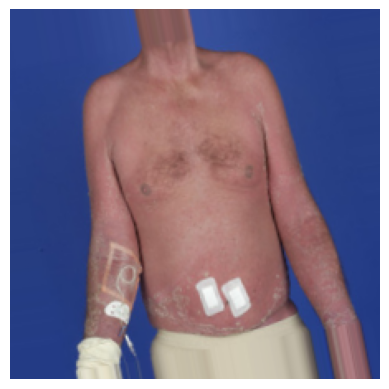

In [ ]:

%pip install scipy

sample = np.expand_dims(img_arr, axis=0)
augmented_img = next(datagen.flow(sample))[0]

plt.imshow(augmented_img)
plt.axis('off')


In [21]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.30
)


In [22]:
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)


Found 8789 images belonging to 8 classes.


In [23]:
val_test_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 3764 images belonging to 8 classes.


In [24]:
import math

val_batches = math.floor(val_test_data.samples * 0.5 / BATCH_SIZE)

val_data = val_test_data
val_data.samples = val_batches * BATCH_SIZE

test_data = val_test_data
test_data.samples = val_test_data.samples - val_data.samples


In [25]:
images, labels = next(train_data)

images.shape, labels.shape


((32, 224, 224, 3), (32, 8))